# Zarr Archive for Training

## Zarr Archive

The zarr index can be a useful way to consolidate data into a large dataset for later ML training.

This example will run through that process, creating a zarr archive, filling it with data and setting it up ready for training

In [1]:
import edit.data
import edit.pipeline

## Data Source
For this tutorial we shall use a small data source to allow for a quick compute, but one which illustrates how to use this approach

In [2]:
era_surface = edit.data.archive.ERA5(['tcwv', 'skt', 'sp'])

In [3]:
zarr_archive_pattern  = edit.data.patterns.ZarrTimeIndex('temp', template = True)
zarr_archive_pattern

ZarrTimeIndex
	Description                    Zarr Archive at '/jobfs/121905549.gadi-pbs/tmp7opnv2f5'.


	Initialisation                 
		 root_dir   PosixPath('/jobfs/121905549...
		 template   True                          
	Transforms                     
		 StandardCoordinateNames {'latitude': "['lat', 'Latitude', 'yt_oce...", 'longitude': "['lon', 'Longitude', 'xt_oc...", 'replacement_dictionary': 'None                          ', 'time': "['Time']                      "}

## Creating the Data Pipeline
We need to create the data pipeline to define the shape of the data, note this does not yet have the cache added, as we still need to define the template.

In [4]:
pipeline = edit.pipeline.Pipeline(
    era_surface,
    edit.pipeline.operations.xarray.reshape.Dimensions(('time', 'latitude', 'longitude')),
    edit.pipeline.operations.xarray.values.FillNan(),
    edit.pipeline.operations.xarray.Chunk(latitude = 721, longitude = 1440, time = 1),
)

## Template

Now that we have the `cache` and the `pipeline`, we need to define the full extent of the data, .i.e create the template of the dataset which will be filled by the pipeline

In [5]:
full_time_values = list(map(lambda x: x.datetime64(), edit.data.TimeRange('1980', '2020', '6 hour')))

In [6]:
zarr_archive_pattern.make_template(pipeline['2000-01-01T00'], time = full_time_values, chunk = {'time': 1, 'latitude':721, 'longitude':1440}, overwrite = True)

Lets check to see if this archive is what we expect

In [7]:
zarr_archive_pattern()

<xarray.Dataset> Size: 1TB
Dimensions:    (latitude: 721, longitude: 1440, time: 58440)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time       (time) datetime64[ns] 468kB 1980-01-01 ... 2019-12-31T18:00:00
Data variables:
    skt        (time, latitude, longitude) float64 485GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    sp         (time, latitude, longitude) float64 485GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float64 485GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...

With the template now defined, this archive can now be written into by multiple processes and the data generation properly distributed

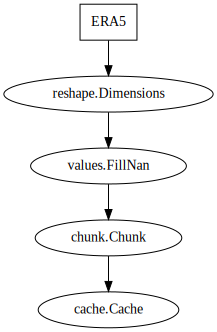

In [8]:
save_pipeline = pipeline + edit.pipeline.modifications.Cache(pattern = zarr_archive_pattern)
save_pipeline

Currently `edit.datasets` is not yet built out enough to accomplish this distributed building of datasets, but hopefully it will be soon. 

For now it is up to you to distribute the computing of this dataset.

## Usage
As `template=True` forces all existence checks to fail to ensure proper cache generation, using this pipeline directly for downstream applications will result in a regeneration of the data.

Therefore, after the data is generated, the cache needs to be changed to use `template=False`. This then will allow for proper usage of the zarr cache

In [9]:
zarr_archive_pattern  = edit.data.patterns.ZarrTimeIndex('temp', template = False)
zarr_archive_pattern

ZarrTimeIndex
	Description                    Zarr Archive at '/jobfs/121905549.gadi-pbs/tmprlq3n4xs'.


	Initialisation                 
		 root_dir   PosixPath('/jobfs/121905549...
		 template   False                         
	Transforms                     
		 StandardCoordinateNames {'latitude': "['lat', 'Latitude', 'yt_oce...", 'longitude': "['lon', 'Longitude', 'xt_oc...", 'replacement_dictionary': 'None                          ', 'time': "['Time']                      "}